# Задача 1. Библиотека OpenMP

Давайте рассмотрим книгу В. П. Гергеля “Высокопроизводительные вычисления для
многоядерных многопроцессорных систем” (2010). В главе 11 "Решение
дифференциальных уравнений в частных производных", описывающей проблему
численного решения задачи Дирихле для уравнения Пуассона, содержится алгоритм
11.6 (Блочный подход к методу волновой обработки данных) её решения, который
может быть эффективно распараллелен при помощи OpenMP.
В первой части задания вам следует просто разобраться в этом алгоритме и
реализовать его. Обратите внимание, что он возникает итерационно. Например,
алгоритм 11.2 является корректным, но распараллеливание приводит к замедлению в
25 раз вместо ускорения.
Вторая часть задания — провести численный эксперимент, исследующий
эффективность (или неэффективность) параллельной версии. Модельные краевые
задачи необходимо выбрать самостоятельно, исходя из того, что вы хотели бы теми
или иными экспериментами продемонстрировать. Это наиболее сложная часть
задания.`

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Теория

Рассмотрим сетку размером `NB x NB` блоков. Посчитаем, сколько "шагов" нужно для обработки всех блоков во время одной итерации.
* Последовательный алгоритм. Очевидно, придется обработать каждый блок, поэтому потребуется `NB * NB` шагов.
* Параллельный алгоритм. Пусть алгоритм исполняется на `nthreads` потоках. Во время параллельного исполнения за один шаг может обрабатываться вплоть до `nthreads` блоков, но только в рамках одной волны. Таким образом, потребуется $2\displaystyle\sum_{i = 1}^{NB - 1} ceil(i / nthreads) + ceil(NB / nthreads)$.

In [168]:
# Functions to calculate number of iters needed for parrallel version and maximum possible acceleration

def get_parallel_iters(NB, num_threads):
    return int(np.ceil(NB / num_threads) + 2 * np.sum([np.ceil(i / num_threads) for i in range(1, int(NB))]))

def get_accel(NB, num_threads):
    return NB * NB / get_parallel_iters(NB, num_threads)

# Эксперимент

Тестовый стенд
* CPU Intel Core i5-12500H × 16 (12 физических ядер)
* 16 GB RAM

Эксперименты проводились для значений:

1. `nthreads = 1, 2, 4, 8`
2. `N = 500, 1000`
3. `block_size = 32, 64, 128, 256, 512`
4. `eps = 0.1`

Ускорение, получаемое при распараллеливании, не может зависить от выбора функции никак, кроме количества итераций. И в параллельной, и в последоватенльной версии в каждом обрабатываемом блоке будут выполняться одни и те же операции одинаковое количество раз, на скорость выполнения этих операций значения в узлах сетки, определяемые выбором модельной функции, влияют очень слабо. Таким образом, выберем две модельные функции, для которых необходимое количество итераций для сходимости алгоритма отличается сильно:


* Задачу из книги
    * $f(x, y) = 0$
    * $g(x, y) = $

        $100 - 200x, ~y = 0$

        $100 - 200y, ~x = 0$

        $-100 + 200x, ~y = 1$

        $-100 + 200y, ~x = 1$

* Задачу 1
    * $f(x, y) = \dfrac{2000}{xy}$
    * $g(x, y) = 100x^2 + 200y^3$

Для каждого набора параметров были запущены 5 итераций, все результаты итераций сохранены в `csv` файлы.

# Цели эксперимента
1. Исследовать зависимость скорости и ускорения в зависимости от размера блока (и количества блоков соответственно).
2. Проверить, влияет ли количество итераций на эффективность параллельной версии на примере двух описанных функций.

In [169]:
book_df = pd.read_csv("csv/Book.csv")
model_df = pd.read_csv("csv/Model1.csv")

In [172]:
print(book_df.shape)
print(model_df.shape)

(24, 10)
(24, 10)


### Во-первых проверим, что все запуски для одних и тех же размеров сетки сошлись с одним количеством итераций

In [173]:
display(book_df[["iterations", "n"]].value_counts())
display(model_df[["iterations", "n"]].value_counts())

iterations  n   
352         1000    24
Name: count, dtype: int64

iterations  n   
5770        1000    24
Name: count, dtype: int64

### Дополним таблицу нужными статистиками, такими как среднее и медианное время, количество блоков.

In [174]:
# Посчитаем серднее и медианное время выполнения
time_cols = [f'time_{i}' for i in range(1, 6)]

book_df["mean_time"] = book_df[time_cols].mean(axis=1).astype(int)
book_df["median_time"] = book_df[time_cols].median(axis=1).astype(int)
book_df["nb"] = book_df.apply(lambda x: x["n"] // x["block_size"] + (1 if x["n"] % x["block_size"] != 0 else 0), axis=1).astype(int)

model_df["mean_time"] = model_df[time_cols].mean(axis=1).astype(int)
model_df["median_time"] = model_df[time_cols].median(axis=1).astype(int)
model_df["nb"] = model_df.apply(lambda x: x["n"] // x["block_size"] + (1 if x["n"] % x["block_size"] != 0 else 0), axis=1).astype(int)


### Нарисуем на графике, как меняется время работы для разных `block_size` с увеличением числа потоков

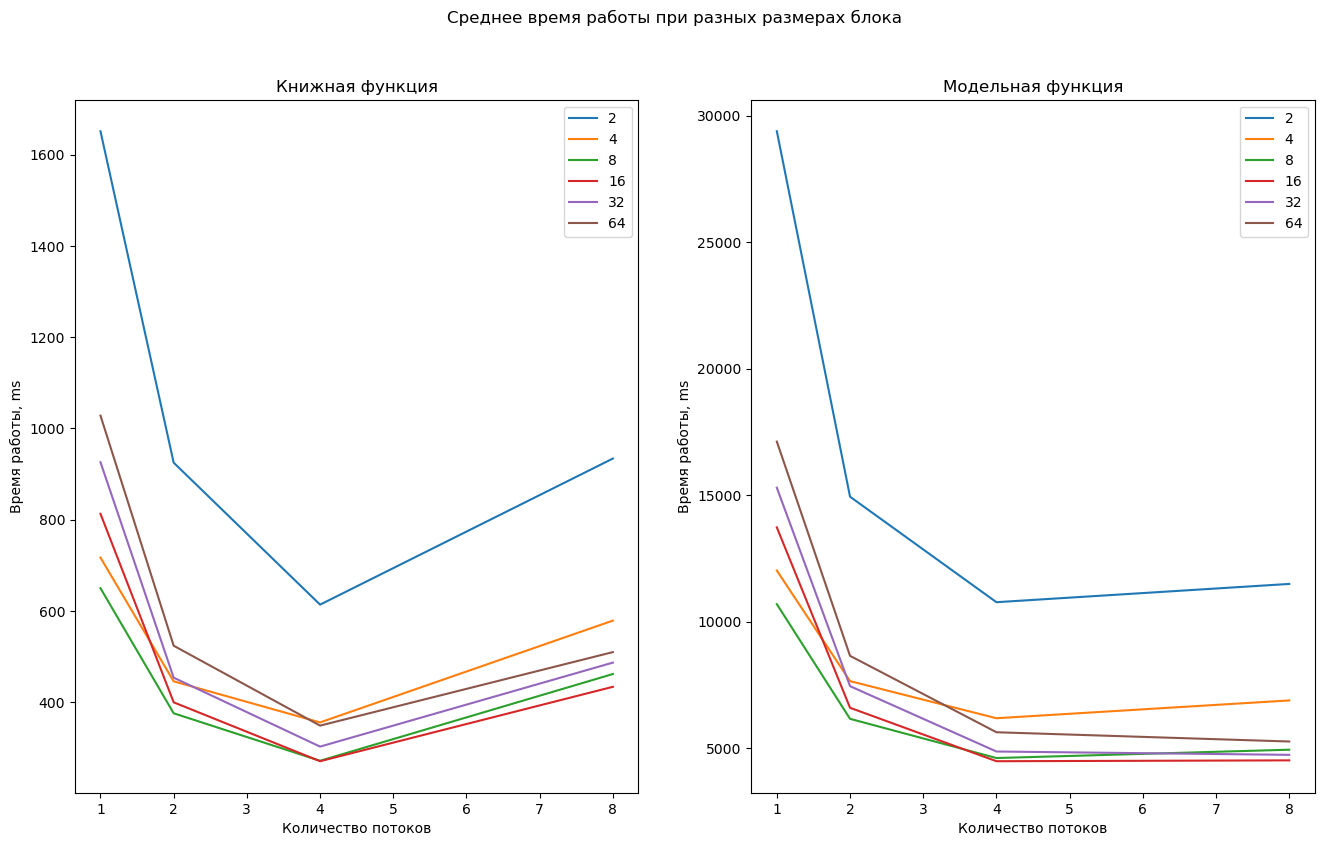

In [175]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
fig.suptitle("Среднее время работы при разных размерах блока")
for block_size in sorted(book_df["block_size"].unique()):
    ax[0].plot(sorted(book_df["nthreads"].unique()), book_df[book_df["block_size"] == block_size]["mean_time"], label=f"{block_size}")
    ax[1].plot(sorted(model_df["nthreads"].unique()), model_df[model_df["block_size"] == block_size]["mean_time"], label=f"{block_size}")

ax[0].set_title("Книжная функция")
ax[0].set_xlabel("Количество потоков")
ax[0].set_ylabel("Время работы, ms")

ax[1].set_title("Модельная функция")
ax[1].set_xlabel("Количество потоков")
ax[1].set_ylabel("Время работы, ms")

ax[0].legend()
ax[1].legend()

Как видно, в среднем при `block_size = 2` алгоритм работает медленнее всего на любом количестве потоков, быстрее всего на 1, 2 и 4 потоках в среднем алгоритм работает при `block_size = 8`. Однако при 8-ми потоках алгоритм сильно проигрывает только при `block_size = 4`, при `block_size = 8, 32, 64` время выполнения очень схожее.

### Посчитаем для каждого измерения максимално возможное и реальное ускорение, а также долю реального ускорения от максимально возможного 

In [176]:
book_df["max_accel"] = book_df.apply(lambda x: get_accel(x["nb"], x["nthreads"]), axis=1).astype(float)
book_df["real_accel"] = book_df.apply(lambda x: book_df[
    (book_df["n"] == x["n"]) & 
    (book_df["block_size"] == x["block_size"]) & 
    (book_df["nthreads"] == 1) 
]["mean_time"].iloc[0] / x["mean_time"], axis=1)
book_df["acсel_ratio"] = book_df["real_accel"] / book_df["max_accel"]

In [177]:
model_df["max_accel"] = model_df.apply(lambda x: get_accel(x["nb"], x["nthreads"]), axis=1).astype(float)
model_df["real_accel"] = model_df.apply(lambda x: model_df[
    (model_df["n"] == x["n"]) & 
    (model_df["block_size"] == x["block_size"]) & 
    (model_df["nthreads"] == 1) 
]["mean_time"].iloc[0] / x["mean_time"], axis=1)
model_df["acсel_ratio"] = model_df["real_accel"] / model_df["max_accel"]

### Построим графики зависимости реального ускорения и доли от максимального ускорения от числа потоков для различных размеров блоков

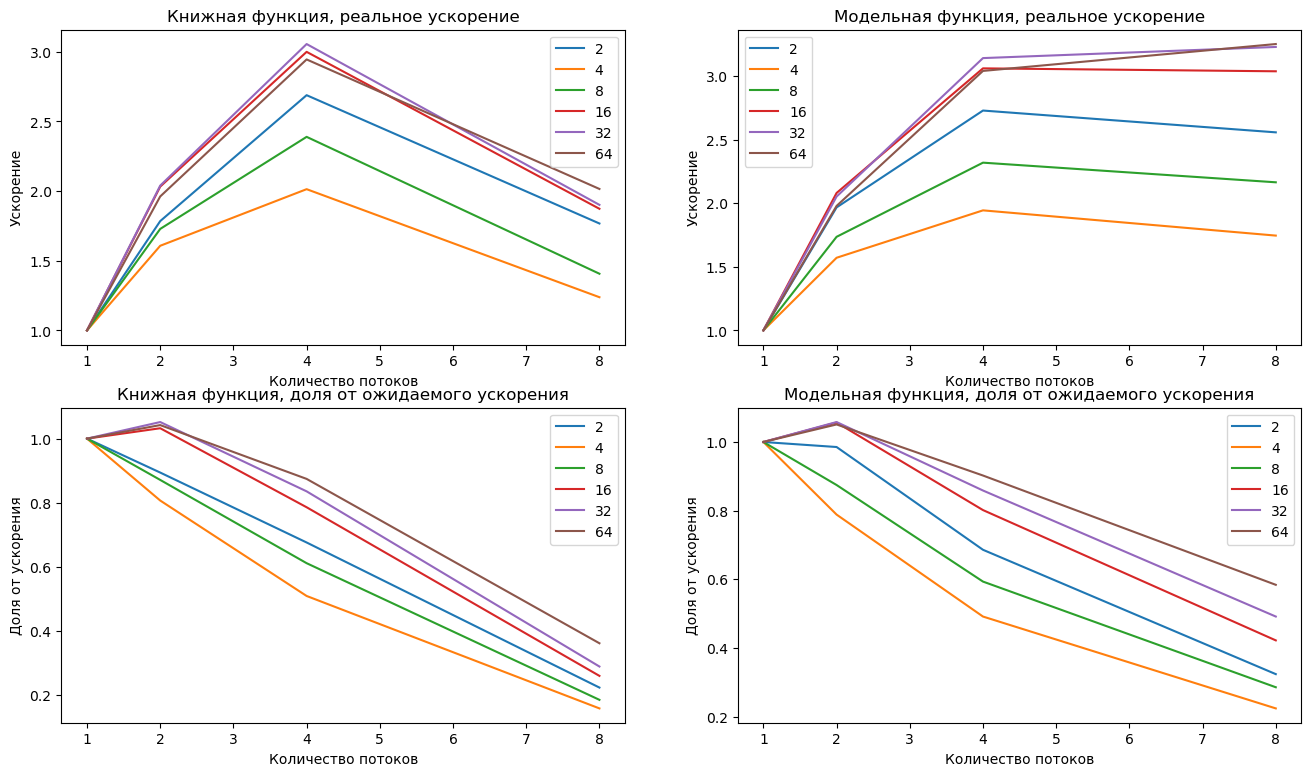

In [178]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9))
for block_size in sorted(book_df["block_size"].unique()):
    ax[0, 0].plot(sorted(book_df["nthreads"].unique()), book_df[book_df["block_size"] == block_size]["real_accel"], label=f"{block_size}")
    ax[0, 1].plot(sorted(model_df["nthreads"].unique()), model_df[model_df["block_size"] == block_size]["real_accel"], label=f"{block_size}")

    ax[1, 0].plot(sorted(book_df["nthreads"].unique()), book_df[book_df["block_size"] == block_size]["acсel_ratio"], label=f"{block_size}")
    ax[1, 1].plot(sorted(model_df["nthreads"].unique()), model_df[model_df["block_size"] == block_size]["acсel_ratio"], label=f"{block_size}")


ax[0, 0].set_title("Книжная функция, реальное ускорение")
ax[0, 0].set_xlabel("Количество потоков")
ax[0, 0].set_ylabel("Ускорение")

ax[0, 1].set_title("Модельная функция, реальное ускорение")
ax[0, 1].set_xlabel("Количество потоков")
ax[0, 1].set_ylabel("Ускорение")

ax[0, 0].legend()
ax[0, 1].legend()

ax[1, 0].set_title("Книжная функция, доля от ожидаемого ускорения")
ax[1, 0].set_xlabel("Количество потоков")
ax[1, 0].set_ylabel("Доля от ускорения")

ax[1, 1].set_title("Модельная функция, доля от ожидаемого ускорения")
ax[1, 1].set_xlabel("Количество потоков")
ax[1, 1].set_ylabel("Доля от ускорения")

ax[1, 0].legend()
ax[1, 1].legend()